# Problem 2: Recurrent Neural Networks

In [19]:
# Download word vectors
from urllib.request import urlretrieve
import os
if not os.path.isfile('mini.h5'):
    print("Downloading Conceptnet Numberbatch word embeddings...")
    conceptnet_url = 'http://conceptnet.s3.amazonaws.com/precomputed-data/2016/numberbatch/17.06/mini.h5'
    urlretrieve(conceptnet_url, 'mini.h5')

In [20]:
import numpy as np
import h5py
with h5py.File('mini.h5', 'r') as f:
    all_words = [word.decode('utf-8') for word in f['mat']['axis1'][:]]
    all_embeddings = f['mat']['block0_values'][:]

In [21]:
english_words = [word[6:] for word in all_words if word.startswith('/c/en/')]
english_word_indices = [i for i, word in enumerate(all_words) if word.startswith('/c/en/')]
english_embedddings = all_embeddings[english_word_indices]

In [22]:
norms = np.linalg.norm(english_embedddings, axis=1)
normalized_embeddings = english_embedddings.astype('float32') / norms.astype('float32').reshape([-1, 1])

In [23]:
index = {word: i for i, word in enumerate(english_words)}

# review dataset to word embedding

### Note: for training efficiency, I will use the simple dataset for training and test

In [4]:
import tensorflow as tf

/Users/junyang/anaconda2/envs/p3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [10]:
import numpy as np

In [24]:
import string
remove_punct=str.maketrans('','',string.punctuation)

# This function converts a line of our data file into
# a tuple (x, y), where x is 300-dimensional representation
# of the words in a review, and y is its label.
def convert_line_to_example(line):
    # Pull out the first character: that's our label (0 or 1)
    y = int(line[0])
    # Split the line into words using Python's split() function
    words = line[2:].translate(remove_punct).lower().split()
    # Look up the embeddings of each word, ignoring words not
    # in our pretrained vocabulary.
    embeddings = [normalized_embeddings[index[w]] for w in words
                  if w in index]
    # Take the mean of the embeddings
    x = np.mean(np.vstack(embeddings), axis=0)
    return {'x': x, 'y': y, 'w':embeddings}

# Apply the function to each line in the file.
# enc = 'utf-8' # This is necessary from within the singularity shell
# with open("Data/movie-simple.txt", "r", encoding=enc) as f:
#     dataset = [convert_line_to_example(l) for l in f.readlines()]

# review dataset to one-hot vector

In [6]:
import string
remove_punct=str.maketrans('','',string.punctuation)

all_words = []
with open("Data/movie-simple.txt", "r") as f:
    for line in f:
        words = line[2:].translate(remove_punct).lower().split()
        all_words.extend(words)
all_words = set(all_words)
simple_word_index = {word:i for i,word in enumerate(all_words)}
print(len(simple_word_index))

def convert_line_to_onehot(line):
    y = int(line[0])
    
    words = line[2:].translate(remove_punct).lower().split()
    
    embeddings = []
    
    for w in words:
        if w in simple_word_index:
            onehot = np.zeros((len(simple_word_index)))
            onehot[simple_word_index[w]] = 1
            embeddings.append(onehot)
    x = np.mean(np.vstack(embeddings), axis = 0)
    return {'x':x, 'y':y, 'w': embeddings}
    

2244


## (i) Train an MLP

In [27]:
tf.reset_default_graph()

# Placeholders for input
X = tf.placeholder(tf.float32, [None, 300])
y = tf.placeholder(tf.float32, [None, 1])

# Three-layer MLP
h1 = tf.layers.dense(X, 100, tf.nn.relu)
h2 = tf.layers.dense(h1, 20, tf.nn.relu)
logits = tf.layers.dense(h2, 1)
probabilities = tf.sigmoid(logits)

# Loss and metrics
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=y))
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.round(tf.sigmoid(logits)), y), tf.float32))

# Training
train_step = tf.train.AdamOptimizer(0.005).minimize(loss)

# Initialization of variables
initialize_all = tf.global_variables_initializer()

In [28]:
# Apply the function to each line in the file.
with open("Data/movie-simple.txt", "r",encoding=enc) as f:
    dataset = [convert_line_to_example(l) for l in f.readlines()]
import random
random.shuffle(dataset)
batch_size = 100
total_batches = len(dataset) // batch_size
train_batches = 3 * total_batches // 4
train, test = dataset[:train_batches*batch_size], dataset[train_batches*batch_size:]
with tf.Session() as sess:
    sess.run(initialize_all)
    for epoch in range(250):
        for batch in range(train_batches):
            data = train[batch*batch_size:(batch+1)*batch_size]
            reviews = [sample['x'] for sample in data]
            labels  = [sample['y'] for sample in data]
            labels = np.array(labels).reshape([-1, 1])
            _, l, acc = sess.run([train_step, loss, accuracy], feed_dict={X: reviews, y: labels})
        if epoch % 100 == 0:
            print("Epoch", epoch, "Loss", l, "Acc", acc)
        random.shuffle(train)

    # Evaluate on test set
    test_reviews = [sample['x'] for sample in test]
    test_labels  = [sample['y'] for sample in test]
    test_labels = np.array(test_labels).reshape([-1, 1])
    acc = sess.run(accuracy, feed_dict={X: test_reviews, y: test_labels})
    print("Final accuracy:", acc)
    sess.close()

Epoch 0 Loss 0.58270746 Acc 0.74
Epoch 100 Loss 0.0008705638 Acc 1.0
Epoch 200 Loss 0.007892927 Acc 0.99
Final accuracy: 0.93430656


## (ii) Train a RNN

In [25]:
 tf.reset_default_graph()
# sizes
n_steps = None
n_inputs = 300
n_neurons = 300
# Build RNN
X= tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y= tf.placeholder(tf.float32, [None, 1])
basic_cell = tf.contrib.rnn.LSTMCell(n_neurons,activation=tf.nn.tanh)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)
last_cell_output=outputs[:,-1,:]
y_=tf.layers.dense(last_cell_output,1)

# Loss and metrics
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_, labels=y))
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.round(tf.sigmoid(y_)), y), tf.float32))

# Training
train_step = tf.train.AdamOptimizer(0.0005).minimize(loss)

In [28]:
with open("Data/movie-simple.txt", "r") as f:
    dataset = [convert_line_to_example(l) for l in f.readlines()]
import random
random.shuffle(dataset)
batch_size = 1
total_batches = len(dataset) // batch_size
train_batches = 3 * total_batches // 4
train, test = dataset[:train_batches*batch_size], dataset[train_batches*batch_size:]

In [29]:
initialize_all = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(initialize_all)
    l_ma=.74
    acc_ma=.5
    for epoch in range(5):
        for batch in range(train_batches):
            data = train[batch*batch_size:(batch+1)*batch_size]
            reviews = np.array([sample['w'] for sample in data]).reshape([1,-1,300])
            labels  = np.array([sample['y'] for sample in data]).reshape([1,1])
            labels = np.array(labels).reshape([-1, 1])
            _, l, acc = sess.run([train_step, loss, accuracy], feed_dict={X: reviews, y: labels})
            l_ma=.99*l_ma+(.01)*l
            acc_ma=.99*acc_ma+(.01)*acc
            if (batch+1) % 100 == 0:
                print("batch", batch, "Loss", l_ma, "Acc", acc_ma)
        if epoch % 1 == 0:
            print("Epoch", epoch, "Loss", l_ma, "Acc", acc_ma)
        random.shuffle(train)
    
    # Evaluate on test set
    test_acc=0
    n=0
    for sample in test:
        test_reviews = np.array([sample['w'] ]).reshape([1,-1,300])
        test_labels  = np.array([sample['y']]).reshape([1,1])
        test_labels = np.array(test_labels).reshape([-1, 1])
        test_acc += sess.run(accuracy, feed_dict={X: test_reviews, y: test_labels})
        n+=1
    acc=test_acc/n 
    print("Final accuracy:", acc)

batch 99 Loss 0.7008613513072177 Acc 0.551455280396043
batch 199 Loss 0.6071107934935648 Acc 0.6892047172414654
batch 299 Loss 0.599821481187099 Acc 0.7583694021681308
batch 399 Loss 0.5773949888616287 Acc 0.7748364293977802
batch 499 Loss 0.5340650834740512 Acc 0.774366030320666
batch 599 Loss 0.44995803652132144 Acc 0.8252974409612284
batch 699 Loss 0.379139558419749 Acc 0.8794375190873532
batch 799 Loss 0.4851781744476916 Acc 0.8398533557332883
batch 899 Loss 0.4214640178864735 Acc 0.8881932205164055
batch 999 Loss 0.3202040381956183 Acc 0.9085800673305947
Epoch 0 Loss 0.3569022545989174 Acc 0.9156982125789035
batch 99 Loss 0.2928791316114479 Acc 0.9003789693814245
batch 199 Loss 0.31149639396411805 Acc 0.891595096850404
batch 299 Loss 0.31091273838878897 Acc 0.8886155073581751
batch 399 Loss 0.2990597156113068 Acc 0.9052552679400063
batch 499 Loss 0.2713981727325468 Acc 0.9175517799140273
batch 599 Loss 0.21293486469343548 Acc 0.9375990809326836
batch 699 Loss 0.1909873428775519 Ac

## (iii) Encode each vocabulary word as a one-hot vector. Train an MLP on the average of the onehot vectors.

In [11]:
tf.reset_default_graph()

# Placeholders for input
X = tf.placeholder(tf.float32, [None, len(simple_word_index)])
y = tf.placeholder(tf.float32, [None, 1])

# Three-layer MLP
h1 = tf.layers.dense(X, 100, tf.nn.relu)
h2 = tf.layers.dense(h1, 20, tf.nn.relu)
logits = tf.layers.dense(h2, 1)
probabilities = tf.sigmoid(logits)

# Loss and metrics
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=y))
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.round(tf.sigmoid(logits)), y), tf.float32))

# Training
train_step = tf.train.AdamOptimizer(0.005).minimize(loss)

# Initialization of variables
initialize_all = tf.global_variables_initializer()

In [13]:
# Apply the function to each line in the file.
with open("Data/movie-simple.txt", "r") as f:
    dataset = [convert_line_to_onehot(l) for l in f.readlines()]
import random
random.shuffle(dataset)
batch_size = 100
total_batches = len(dataset) // batch_size
train_batches = 3 * total_batches // 4
train, test = dataset[:train_batches*batch_size], dataset[train_batches*batch_size:]
with tf.Session() as sess:
    sess.run(initialize_all)
    for epoch in range(500):
        for batch in range(train_batches):
            data = train[batch*batch_size:(batch+1)*batch_size]
            reviews = [sample['x'] for sample in data]
            labels  = [sample['y'] for sample in data]
            labels = np.array(labels).reshape([-1, 1])
            _, l, acc = sess.run([train_step, loss, accuracy], feed_dict={X: reviews, y: labels})
        if epoch % 100 == 0:
            print("Epoch", epoch, "Loss", l, "Acc", acc)
        random.shuffle(train)

    # Evaluate on test set
    test_reviews = [sample['x'] for sample in test]
    test_labels  = [sample['y'] for sample in test]
    test_labels = np.array(test_labels).reshape([-1, 1])
    acc = sess.run(accuracy, feed_dict={X: test_reviews, y: test_labels})
    print("Final accuracy:", acc)
    sess.close()

Epoch 0 Loss 0.66229296 Acc 0.57
Epoch 100 Loss 9.808573e-05 Acc 1.0
Epoch 200 Loss 3.8987673e-05 Acc 1.0
Epoch 300 Loss 2.0276948e-05 Acc 1.0
Epoch 400 Loss 6.077886e-06 Acc 1.0
Final accuracy: 0.92214113


## (iv) use an RNN on the one-hot encodings

In [30]:
tf.reset_default_graph()
# sizes
n_steps = None
n_inputs = len(simple_word_index)
n_neurons = 300
# Build RNN
X= tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y= tf.placeholder(tf.float32, [None, 1])
basic_cell = tf.contrib.rnn.LSTMCell(n_neurons,activation=tf.nn.tanh)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)
last_cell_output=outputs[:,-1,:]
y_=tf.layers.dense(last_cell_output,1)

# Loss and metrics
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_, labels=y))
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.round(tf.sigmoid(y_)), y), tf.float32))

# Training
train_step = tf.train.AdamOptimizer(0.0005).minimize(loss)

In [31]:
with open("Data/movie-simple.txt", "r") as f:
    dataset = [convert_line_to_onehot(l) for l in f.readlines()]
import random
random.shuffle(dataset)
batch_size = 1
total_batches = len(dataset) // batch_size
train_batches = 3 * total_batches // 4
train, test = dataset[:train_batches*batch_size], dataset[train_batches*batch_size:]

In [32]:
initialize_all = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(initialize_all)
    l_ma=.74
    acc_ma=.5
    for epoch in range(5):
        for batch in range(train_batches):
            data = train[batch*batch_size:(batch+1)*batch_size]
            reviews = np.array([sample['w'] for sample in data]).reshape([1,-1,n_inputs])
            labels  = np.array([sample['y'] for sample in data]).reshape([1,1])
            labels = np.array(labels).reshape([-1, 1])
            _, l, acc = sess.run([train_step, loss, accuracy], feed_dict={X: reviews, y: labels})
            l_ma=.99*l_ma+(.01)*l
            acc_ma=.99*acc_ma+(.01)*acc
            if (batch+1) % 100 == 0:
                print("batch", batch, "Loss", l_ma, "Acc", acc_ma)
        if epoch % 1 == 0:
            print("Epoch", epoch, "Loss", l_ma, "Acc", acc_ma)
        random.shuffle(train)
    
    # Evaluate on test set
    test_acc=0
    n=0
    for sample in test:
        test_reviews = np.array([sample['w'] ]).reshape([1,-1,n_inputs])
        test_labels  = np.array([sample['y']]).reshape([1,1])
        test_labels = np.array(test_labels).reshape([-1, 1])
        test_acc += sess.run(accuracy, feed_dict={X: test_reviews, y: test_labels})
        n+=1
    acc=test_acc/n 
    print("Final accuracy:", acc)

batch 99 Loss 0.7018034665524666 Acc 0.6137262050185035
batch 199 Loss 0.6650306217632619 Acc 0.6847164359915606
batch 299 Loss 0.8593056257885437 Acc 0.747397783000925
batch 399 Loss 0.6972985635082203 Acc 0.7939420257041881
batch 499 Loss 0.6397439193551273 Acc 0.7718455526820739
batch 599 Loss 0.5891593253873249 Acc 0.7564376721785917
batch 699 Loss 0.5079285483578966 Acc 0.8262492266807091
batch 799 Loss 0.5615120526901012 Acc 0.7617777452162022
batch 899 Loss 0.5564540600228293 Acc 0.7748109639963837
batch 999 Loss 0.538993645045267 Acc 0.7857206188147822
Epoch 0 Loss 0.4896491003931777 Acc 0.8299802721451672
batch 99 Loss 0.4109330079550659 Acc 0.8799148666330606
batch 199 Loss 0.31445687090958546 Acc 0.9280992032734932
batch 299 Loss 0.45165204365409156 Acc 0.934406877086922
batch 399 Loss 0.3592265380861536 Acc 0.9427632412688144
batch 499 Loss 0.37407234529746497 Acc 0.9191369213983333
batch 599 Loss 0.3913232640837716 Acc 0.8924453416154167
batch 699 Loss 0.26587172930488845 

## (v) Why did the word embeddings work better 

As training results shown above, using word embedding, MLP and RNN could achieve test accuracy of 0.9343 and 0.9546, respectively. While using one-hot encodings, MLP and RNN have test accuracy of 0.9221 abd 0.8810, respectively.
Word embeddings work better on the task of sentiment analysis.

Word embeddings could represent the similarities among words, which is a more informative representation/feature of words. On the contrary, the one-hot encodings don't express the relationship among words.



## (vi) How does cross-validation change when considering a time-series instead of multipleinstances (as in our movie reviews)? Only a description is needed.

High-level idea: we only predict forward!

1. Break the time series into K contiguous (in time) chunks
2. For k in 1:K-1:
        train the first k chunks, predict on (k+1)th chunk

## (vii) In our previous homework assignment we considered the conditional GAN. In that case, the conditional label was known and given. Instead, consider generating images to match text. One approach could be to use an RNN to encode text to a vector that is fed to a conditional GAN. Draw a graph (but do not implement) how such a system could work. Any implementation here is completely optional, we are only looking for a description of how this could work.

# Problem 4: SARSA Q-Learning

# (a) Implement a deep Q-learning approach to the cart pole problem (was done in class) using an $\epsilon$-Greedy approach

In [19]:
# Based on: https://gym.openai.com/evaluations/eval_EIcM1ZBnQW2LBaFN6FY65g/
import gym
import random
import math
import numpy as np
import tensorflow as tf
from collections import deque

class DQNCartPoleSolver():
    def __init__(self, n_episodes=1000, n_win_ticks=195, max_env_steps=None, gamma=1.0, epsilon=1.0, epsilon_min=0.01, epsilon_log_decay=0.995, alpha=0.01, alpha_decay=0.01, batch_size=64, monitor=False, quiet=False):
        self.memory = deque(maxlen=100000)
        self.env = gym.make('CartPole-v0')
        if monitor: self.env = gym.wrappers.Monitor(self.env, '../data/cartpole-1', force=True)
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_log_decay
        self.alpha = alpha
        self.alpha_decay = alpha_decay
        self.n_episodes = n_episodes
        self.n_win_ticks = n_win_ticks
        self.batch_size = batch_size
        self.quiet = quiet
        if max_env_steps is not None: self.env._max_episode_steps = max_env_steps

        # Init model
        self.state_ = tf.placeholder(tf.float32, shape=[None, 4])
        h = tf.layers.dense(self.state_, units=24, activation=tf.nn.tanh)
        h = tf.layers.dense(h, units=48, activation=tf.nn.tanh)
        self.Q = tf.layers.dense(h, units=2)
        
        self.Q_ = tf.placeholder(tf.float32, shape=[None, 2])
        loss = tf.losses.mean_squared_error(self.Q_, self.Q)
        self.global_step = tf.Variable(0, name='global_step', trainable=False)
        lr = tf.train.exponential_decay(0.01, self.global_step, 0.995, 1)
        self.train_step = tf.train.AdamOptimizer(lr).minimize(loss, global_step=self.global_step)
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state, epsilon):
        return self.env.action_space.sample() if (np.random.random() <= epsilon) else np.argmax(self.sess.run(self.Q, feed_dict={self.state_: state}))

    def get_epsilon(self, t):
        return self.epsilon
#         return max(self.epsilon_min, min(self.epsilon, 1.0 - math.log10((t + 1) * self.epsilon_decay)))

    def preprocess_state(self, state):
        return np.reshape(state, [1, 4])

    def replay(self, batch_size):
        x_batch, y_batch = [], []
        minibatch = random.sample(
            self.memory, min(len(self.memory), batch_size))
        for state, action, reward, next_state, done in minibatch:
            y_target = self.sess.run(self.Q, feed_dict={self.state_: state})
            y_target[0][action] = reward if done else reward + self.gamma * np.max(self.sess.run(self.Q, feed_dict={self.state_: next_state})[0])
            x_batch.append(state[0])
            y_batch.append(y_target[0])
        
        self.sess.run(self.train_step, feed_dict={self.state_: np.array(x_batch), self.Q_: np.array(y_batch)})

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def run(self):
        scores = deque(maxlen=100)

        for e in range(self.n_episodes):
            state = self.preprocess_state(self.env.reset())
            done = False
            i = 0
            while not done:
#                 if e % 100 == 0 and not self.quiet:
#                     self.env.render()
                action = self.choose_action(state, self.get_epsilon(e))
                next_state, reward, done, _ = self.env.step(action)
                next_state = self.preprocess_state(next_state)
                self.remember(state, action, reward, next_state, done)
                state = next_state
                i += 1

            scores.append(i)
            mean_score = np.mean(scores)
            if mean_score >= self.n_win_ticks and e >= 100:
                if not self.quiet: print('Ran {} episodes. Solved after {} trials ✔'.format(e, e - 100))
                return e - 100
            if e % 100 == 0 and not self.quiet:
                print('[Episode {}] - Mean survival time over last 100 episodes was {} ticks.'.format(e, mean_score))

            self.replay(self.batch_size)
        
        if not self.quiet: print('Did not solve after {} episodes 😞'.format(e))
        return e

# if __name__ == '__main__':
#     agent = DQNCartPoleSolver()
#     agent.run() 

## (b) Implement a SARSA approach with a deep network to solve the cart pole problem using an $\epsilon$-Greedy approach

In [1]:
# Based on: https://gym.openai.com/evaluations/eval_EIcM1ZBnQW2LBaFN6FY65g/
import gym
import random
import math
import numpy as np
import tensorflow as tf
from collections import deque
class DQNCartPoleSolver_SARSA():
    def __init__(self, n_episodes=1000, n_win_ticks=195, max_env_steps=None, gamma=1.0, epsilon=1.0, epsilon_min=0.01, epsilon_log_decay=0.995, alpha=0.01, alpha_decay=0.01, batch_size=64, monitor=False, quiet=False):
        self.memory = deque(maxlen=100000)
        self.env = gym.make('CartPole-v0')
        if monitor: self.env = gym.wrappers.Monitor(self.env, '../data/cartpole-1', force=True)
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_log_decay
        self.alpha = alpha
        self.alpha_decay = alpha_decay
        self.n_episodes = n_episodes
        self.n_win_ticks = n_win_ticks
        self.batch_size = batch_size
        self.quiet = quiet
        if max_env_steps is not None: self.env._max_episode_steps = max_env_steps

        # Init model
        self.state_ = tf.placeholder(tf.float32, shape=[None, 4])
        h = tf.layers.dense(self.state_, units=24, activation=tf.nn.tanh)
        h = tf.layers.dense(h, units=48, activation=tf.nn.tanh)
        self.Q = tf.layers.dense(h, units=2)
        
        self.Q_ = tf.placeholder(tf.float32, shape=[None, 2])
        loss = tf.losses.mean_squared_error(self.Q_, self.Q)
        self.global_step = tf.Variable(0, name='global_step', trainable=False)
        lr = tf.train.exponential_decay(0.01, self.global_step, 0.995, 1)
        self.train_step = tf.train.AdamOptimizer(lr).minimize(loss, global_step=self.global_step)
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())

    def remember(self, state, action, reward, next_state, next_action, done):
        self.memory.append((state, action, reward, next_state, next_action, done))

    def choose_action(self, state, epsilon):
        return self.env.action_space.sample() if (np.random.random() <= epsilon) else np.argmax(self.sess.run(self.Q, feed_dict={self.state_: state}))

    def get_epsilon(self, t):
        return self.epsilon
        # return max(self.epsilon_min, min(self.epsilon, 1.0 - math.log10((t + 1) * self.epsilon_decay)))

    def preprocess_state(self, state):
        return np.reshape(state, [1, 4])

    def replay(self, batch_size):
        x_batch, y_batch = [], []
        minibatch = random.sample(
            self.memory, min(len(self.memory), batch_size))
        for state, action, reward, next_state, next_action, done in minibatch:
            y_target = self.sess.run(self.Q, feed_dict={self.state_: state})
            y_target_next = self.sess.run(self.Q, feed_dict={self.state_: next_state})
            y_target[0][action] = reward if done else reward + self.gamma * y_target_next[0][next_action]
            x_batch.append(state[0])
            y_batch.append(y_target[0])
        
        self.sess.run(self.train_step, feed_dict={self.state_: np.array(x_batch), self.Q_: np.array(y_batch)})

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def run(self):
        scores = deque(maxlen=100)

        for e in range(self.n_episodes):
            state = self.preprocess_state(self.env.reset())
            done = False
            i = 0
            while not done:
#                 if e % 100 == 0 and not self.quiet:
#                     self.env.render()
                action = self.choose_action(state, self.get_epsilon(e))
                next_state, reward, done, _ = self.env.step(action)
                next_state = self.preprocess_state(next_state)
                next_action = self.choose_action(next_state, self.get_epsilon(e))
                self.remember(state, action, reward, next_state, next_action, done)
                state = next_state
                i += 1

            scores.append(i)
            mean_score = np.mean(scores)
            if mean_score >= self.n_win_ticks and e >= 100:
                if not self.quiet: print('Ran {} episodes. Solved after {} trials ✔'.format(e, e - 100))
                return e - 100
            if e % 100 == 0 and not self.quiet:
                print('[Episode {}] - Mean survival time over last 100 episodes was {} ticks.'.format(e, mean_score))

            self.replay(self.batch_size)
        
        if not self.quiet: print('Did not solve after {} episodes 😞'.format(e))
        return e

# if __name__ == '__main__':
#     agent = DQNCartPoleSolver_SARSA()
#     agent.run() 

/Users/junyang/anaconda2/envs/p3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## (c) Evaluate the impact of $\gamma$ in the cart pole problem. How important is this parameter? How does it affect stability and learning?

As experiments shown above, both in the setting of Q-learning and SARSA learning, $\gamma$ is a important parameter.

Generally speaking, a larger $\gamma$ will encourage the agent to choose action that leads to larger future rewards, while a smaller $\gamma$ will make agent more prefer getting the instantanenous rewards. In terms of stability and learning, a larger value of $\gamma$ leads to a faster learning process (less epsisodes needed) and better policy (in terms of number of ticks)

### Q-Learning

In [9]:
agent = DQNCartPoleSolver()
agent.run() 

[Episode 0] - Mean survival time over last 100 episodes was 10.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 14.26 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 40.87 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 93.47 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 115.26 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 137.36 ticks.
[Episode 600] - Mean survival time over last 100 episodes was 128.8 ticks.
[Episode 700] - Mean survival time over last 100 episodes was 100.22 ticks.
[Episode 800] - Mean survival time over last 100 episodes was 119.01 ticks.
[Episode 900] - Mean survival time over last 100 episodes was 145.93 ticks.
Did not solve after 999 episodes 😞


999

In [10]:
agent = DQNCartPoleSolver(gamma=0.8)
agent.run() 

[Episode 0] - Mean survival time over last 100 episodes was 26.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 25.83 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 121.73 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 173.18 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 160.41 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 157.81 ticks.
[Episode 600] - Mean survival time over last 100 episodes was 138.74 ticks.
[Episode 700] - Mean survival time over last 100 episodes was 132.68 ticks.
[Episode 800] - Mean survival time over last 100 episodes was 147.8 ticks.
[Episode 900] - Mean survival time over last 100 episodes was 122.25 ticks.
Did not solve after 999 episodes 😞


999

In [11]:
agent = DQNCartPoleSolver(gamma=0.5)
agent.run() 

[Episode 0] - Mean survival time over last 100 episodes was 12.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 11.75 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 23.16 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 21.33 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 26.23 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 41.7 ticks.
[Episode 600] - Mean survival time over last 100 episodes was 63.32 ticks.
[Episode 700] - Mean survival time over last 100 episodes was 85.45 ticks.
[Episode 800] - Mean survival time over last 100 episodes was 86.38 ticks.
[Episode 900] - Mean survival time over last 100 episodes was 69.04 ticks.
Did not solve after 999 episodes 😞


999

In [12]:
agent = DQNCartPoleSolver(gamma=0.1)
agent.run() 

[Episode 0] - Mean survival time over last 100 episodes was 30.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 11.54 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 10.14 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 10.01 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 9.83 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 9.88 ticks.
[Episode 600] - Mean survival time over last 100 episodes was 9.65 ticks.
[Episode 700] - Mean survival time over last 100 episodes was 9.63 ticks.
[Episode 800] - Mean survival time over last 100 episodes was 9.48 ticks.
[Episode 900] - Mean survival time over last 100 episodes was 9.51 ticks.
Did not solve after 999 episodes 😞


999

### SARSA 

In [13]:
agent = DQNCartPoleSolver_SARSA()
agent.run() 

[Episode 0] - Mean survival time over last 100 episodes was 24.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 25.06 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 93.57 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 180.63 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 182.72 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 193.82 ticks.
Ran 508 episodes. Solved after 408 trials ✔


408

In [14]:
agent = DQNCartPoleSolver_SARSA(gamma=0.8)
agent.run() 

[Episode 0] - Mean survival time over last 100 episodes was 13.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 21.94 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 76.01 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 155.39 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 161.88 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 161.11 ticks.
[Episode 600] - Mean survival time over last 100 episodes was 151.51 ticks.
[Episode 700] - Mean survival time over last 100 episodes was 170.66 ticks.
[Episode 800] - Mean survival time over last 100 episodes was 173.04 ticks.
[Episode 900] - Mean survival time over last 100 episodes was 165.44 ticks.
Did not solve after 999 episodes 😞


999

In [15]:
agent = DQNCartPoleSolver_SARSA(gamma=0.5)
agent.run() 

[Episode 0] - Mean survival time over last 100 episodes was 10.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 14.62 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 17.52 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 26.5 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 27.19 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 37.16 ticks.
[Episode 600] - Mean survival time over last 100 episodes was 56.83 ticks.
[Episode 700] - Mean survival time over last 100 episodes was 42.53 ticks.
[Episode 800] - Mean survival time over last 100 episodes was 74.55 ticks.
[Episode 900] - Mean survival time over last 100 episodes was 46.39 ticks.
Did not solve after 999 episodes 😞


999

In [16]:
agent = DQNCartPoleSolver_SARSA(gamma=0.3)
agent.run() 

[Episode 0] - Mean survival time over last 100 episodes was 14.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 14.54 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 18.88 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 21.44 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 25.27 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 32.53 ticks.
[Episode 600] - Mean survival time over last 100 episodes was 37.87 ticks.
[Episode 700] - Mean survival time over last 100 episodes was 58.5 ticks.
[Episode 800] - Mean survival time over last 100 episodes was 55.5 ticks.
[Episode 900] - Mean survival time over last 100 episodes was 57.68 ticks.
Did not solve after 999 episodes 😞


999

## (d) Evaluate the impact of $\epsilon$ on the learning over the feasible range (0-1). What values seem reasonable?

For Q-learning, a large (close to 1) or a small (close to 0) value of $\epsilon$ leads to poor learning performance. Set $\epsilon$ around 0.5, seems a good choice.

For SARSA learning, a large (close to 1) value of $\epsilon$ has better performance - less variability and faster convergence. Set $\epsilon$ greater than 0.9 seems a reasonable choice.

A better and systematic way (as previously coded) of setting of $\epsilon$ is as follows. At first, make it 1. As we don't know anything about the Q-table, it's better to explore. Then gradually make it smaller. We have a better Q-table or a policy through learning, so it makes more sense that we choose our action according to the learned information rather than take s random guess.

In [21]:
agent = DQNCartPoleSolver(epsilon=0.8)
agent.run() 

[Episode 0] - Mean survival time over last 100 episodes was 42.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 21.02 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 37.07 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 70.68 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 73.99 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 76.95 ticks.
[Episode 600] - Mean survival time over last 100 episodes was 97.49 ticks.
[Episode 700] - Mean survival time over last 100 episodes was 103.81 ticks.
[Episode 800] - Mean survival time over last 100 episodes was 79.41 ticks.
[Episode 900] - Mean survival time over last 100 episodes was 115.42 ticks.
Did not solve after 999 episodes 😞


999

In [22]:
agent = DQNCartPoleSolver(epsilon=0.5)
agent.run() 

[Episode 0] - Mean survival time over last 100 episodes was 17.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 17.84 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 49.34 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 95.8 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 95.89 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 140.88 ticks.
[Episode 600] - Mean survival time over last 100 episodes was 116.29 ticks.
[Episode 700] - Mean survival time over last 100 episodes was 136.06 ticks.
[Episode 800] - Mean survival time over last 100 episodes was 145.12 ticks.
[Episode 900] - Mean survival time over last 100 episodes was 184.24 ticks.
Ran 918 episodes. Solved after 818 trials ✔


818

In [29]:
agent = DQNCartPoleSolver(epsilon=0.6)
agent.run() 

[Episode 0] - Mean survival time over last 100 episodes was 31.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 21.68 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 31.49 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 42.39 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 89.15 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 119.76 ticks.
[Episode 600] - Mean survival time over last 100 episodes was 122.95 ticks.
[Episode 700] - Mean survival time over last 100 episodes was 79.75 ticks.
Ran 799 episodes. Solved after 699 trials ✔


699

In [23]:
agent = DQNCartPoleSolver(epsilon=0.3)
agent.run() 

[Episode 0] - Mean survival time over last 100 episodes was 11.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 20.46 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 60.87 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 98.37 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 128.29 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 114.15 ticks.
[Episode 600] - Mean survival time over last 100 episodes was 121.06 ticks.
[Episode 700] - Mean survival time over last 100 episodes was 175.03 ticks.
[Episode 800] - Mean survival time over last 100 episodes was 169.48 ticks.
[Episode 900] - Mean survival time over last 100 episodes was 194.19 ticks.
Did not solve after 999 episodes 😞


999

In [24]:
agent = DQNCartPoleSolver(epsilon=0.1)
agent.run() 

[Episode 0] - Mean survival time over last 100 episodes was 11.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 22.23 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 68.09 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 124.45 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 107.64 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 143.95 ticks.
[Episode 600] - Mean survival time over last 100 episodes was 109.9 ticks.
[Episode 700] - Mean survival time over last 100 episodes was 95.5 ticks.
[Episode 800] - Mean survival time over last 100 episodes was 122.7 ticks.
[Episode 900] - Mean survival time over last 100 episodes was 141.96 ticks.
Did not solve after 999 episodes 😞


999

In [25]:
agent = DQNCartPoleSolver_SARSA(gamma=0.9)
agent.run() 

[Episode 0] - Mean survival time over last 100 episodes was 24.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 28.74 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 111.68 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 187.64 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 193.09 ticks.
Ran 449 episodes. Solved after 349 trials ✔


349

In [30]:
agent = DQNCartPoleSolver_SARSA(gamma=0.95)
agent.run() 

[Episode 0] - Mean survival time over last 100 episodes was 20.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 25.52 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 90.18 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 167.33 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 182.37 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 192.0 ticks.
Ran 532 episodes. Solved after 432 trials ✔


432

In [26]:
agent = DQNCartPoleSolver_SARSA(gamma=0.7)
agent.run() 

[Episode 0] - Mean survival time over last 100 episodes was 20.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 22.18 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 57.25 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 104.49 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 126.37 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 135.32 ticks.
[Episode 600] - Mean survival time over last 100 episodes was 153.7 ticks.
[Episode 700] - Mean survival time over last 100 episodes was 160.73 ticks.
[Episode 800] - Mean survival time over last 100 episodes was 135.53 ticks.
[Episode 900] - Mean survival time over last 100 episodes was 170.93 ticks.
Did not solve after 999 episodes 😞


999

In [27]:
agent = DQNCartPoleSolver_SARSA(gamma=0.5)
agent.run() 

[Episode 0] - Mean survival time over last 100 episodes was 42.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 21.87 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 30.88 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 34.53 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 43.08 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 65.01 ticks.
[Episode 600] - Mean survival time over last 100 episodes was 99.01 ticks.
[Episode 700] - Mean survival time over last 100 episodes was 112.0 ticks.
[Episode 800] - Mean survival time over last 100 episodes was 83.08 ticks.
[Episode 900] - Mean survival time over last 100 episodes was 90.12 ticks.
Did not solve after 999 episodes 😞


999

In [28]:
agent = DQNCartPoleSolver_SARSA(gamma=0.1)
agent.run() 

[Episode 0] - Mean survival time over last 100 episodes was 11.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 20.21 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 16.35 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 15.32 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 17.7 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 15.41 ticks.
[Episode 600] - Mean survival time over last 100 episodes was 13.37 ticks.
[Episode 700] - Mean survival time over last 100 episodes was 12.24 ticks.
[Episode 800] - Mean survival time over last 100 episodes was 12.36 ticks.
[Episode 900] - Mean survival time over last 100 episodes was 11.98 ticks.
Did not solve after 999 episodes 😞


999

## (e)  MountainCar using Deep Q-learning

In [1]:
import gym
import random
import math
import numpy as np
import tensorflow as tf
from collections import deque

/Users/junyang/anaconda2/envs/p3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [263]:
env.reset()

array([-0.42911223,  0.        ])

In [264]:
env.step(1)

(array([-0.42981143, -0.0006992 ]), -1.0, False, {})

-1.0


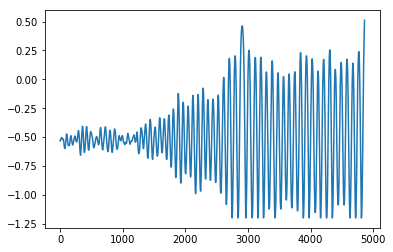

In [285]:
import matplotlib.pyplot as plt
done = False
state = env.reset()
pos = []
while not done:
    action = env.action_space.sample()
    next_state, reward,done,_ = env.step(action)
    pos.append(next_state[0])
    if next_state[0] > 0.5:
        done = True
    state = next_state
print(reward)
plt.plot(pos)
plt.show()

In [23]:
class DQNMCSolver():
    def __init__(self, n_episodes=10000, target_reward=-110, gamma=1.0, epsilon=0.02, epsilon_min=0.01, epsilon_log_decay=0.995, alpha=0.01, alpha_decay=0.01, batch_size=128):
        self.memory = deque(maxlen=100000)
        self.env = gym.make('MountainCar-v0').env
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_log_decay
        self.alpha = alpha
        self.alpha_decay = alpha_decay
        self.n_episodes = n_episodes
        self.target_reward = target_reward
        self.batch_size = batch_size
        self.states_pool = set()

        # Init model
        self.state_ = tf.placeholder(tf.float32, shape=[None, 2])
        #h = tf.layers.dense(self.state_, units=256, activation=tf.nn.relu)
        #h = tf.layers.dense(h, units=64, activation=tf.nn.relu)
        h = tf.layers.dense(self.state_, units=16, activation=tf.nn.relu)
        self.Q = tf.layers.dense(h, units=3)
        
        self.Q_ = tf.placeholder(tf.float32, shape=[None, 3])
        loss = tf.losses.mean_squared_error(self.Q_, self.Q)
        self.global_step = tf.Variable(0, name='global_step', trainable=False)
        lr = tf.train.exponential_decay(0.01, self.global_step, 0.995, 1)
        self.train_step = tf.train.AdamOptimizer(lr).minimize(loss, global_step=self.global_step)
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    

    def choose_action(self, state, epsilon):
        #return self.env.action_space.sample() if (np.random.random() <= epsilon) else np.argmax(self.sess.run(self.Q, feed_dict={self.state_: state}))
        if np.random.random() <= epsilon:
            return self.env.action_space.sample()
        else:
            logits = self.sess.run(self.Q, feed_dict={self.state_: state})
            logits_exp = np.exp(logits)
            probs = logits_exp / np.sum(logits_exp)
            return np.random.choice(self.env.action_space.n, p=probs[0])
    
    def preprocess_state(self, state):
        return np.reshape(state, [1, 2])

    def replay(self, batch_size):
        x_batch, y_batch = [], []
        minibatch = random.sample(
            self.memory, min(len(self.memory), batch_size))
        if len(minibatch) > 1:
            
            for state, action, reward, next_state, done in minibatch:
                y_target = self.sess.run(self.Q, feed_dict={self.state_: state})
                y_target[0][action] = reward if done else reward + self.gamma * np.max(self.sess.run(self.Q, feed_dict={self.state_: next_state})[0])
                x_batch.append(state[0])
                y_batch.append(y_target[0])

            self.sess.run(self.train_step, feed_dict={self.state_: np.array(x_batch), self.Q_: np.array(y_batch)})

    def run(self):
        scores = deque(maxlen=100)
        eps = self.epsilon  # initialize epsilon
        for e in range(self.n_episodes):
            candidate_pool = []
            state = self.preprocess_state(self.env.reset())
            done = False
            score = 0
            i = 0
            current_epsilon = eps
            for _ in range(5000):
                action = self.choose_action(state, current_epsilon)
                next_state, reward, done, _ = self.env.step(action)
                next_state = self.preprocess_state(next_state)
                self.remember(state, action, reward, next_state, done)
                state = next_state
                score += reward
                if done:
                    break
                i += 1
            scores.append(-i)
            mean_score = np.mean(scores)
            max_score = np.max(scores)

            if mean_score >= self.target_reward and e >= 100:
                print('Mean reward:{}, maximum reward:{}'.format(mean_score, max_score))
                print('Ran {} episodes. Solved after {} trials ✔'.format(e, e - 100))
                return e - 100
            if e % 100 == 0:
                
                print('[Episode {}] - Mean reward over last 100 episodes was {}, maximum was {}, epsilon:{}.'\
                      .format(e, mean_score, max_score, current_epsilon))
            
            self.replay(self.batch_size)
        
        return e

In [ ]:
agent = DQNMCSolver(epsilon=0.2, gamma= 0.6, epsilon_log_decay=0.99)
agent.run() 

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
[Episode 0] - Mean reward over last 100 episodes was -5000.0, maximum was -5000, epsilon:0.2.


## Discussions:

MountainCar is a more difficult problem than CartPole:

(1) There is no explicit rewards for each state-action pair until it finally succeeds. This will make learning hard, as there is no difference between unsucessful epsisodes - our nerual network just learns random noises.

(2) It's hard to use random actions to achieve the goal - we have to try many random epsisodes just to have very few successful episodes for learning.

(3) The default MountainCar environment setting makes the episode stop at 200 time steps - no matter whether it achieves the goal, it will return "done" as true. This basically makes the problem even harder as using random actions, it's even less probability that the car could achieve the goal in just 200 steps.

So directly applying the Deep Q-learning on the MountainCar problem is not a good solution. As the training results shown above, we can't learn any good policy (succeed in less than 110 time steps) even after 10000 episodes. 

# MountainCar using Q-learning - discretize continuous  2D states into 2D Q-function table

In [2]:

"""
Q-Learning example using OpenAI gym MountainCar enviornment
Based on https://medium.com/@m.alzantot/deep-reinforcement-learning-demysitifed-episode-2-policy-iteration-value-iteration-and-q-978f9e89ddaa
"""

n_states = 50
iter_max = 10000

initial_lr = 1.0 # Learning rate
min_lr = 0.003
gamma = 1.0
t_max = 10000
eps = 0.02

def run_episode(env, policy=None, render=False):
    obs = env.reset()
    total_reward = 0
    step_idx = 0
    for _ in range(t_max):
        if render:
            env.render()
        if policy is None:
            action = env.action_space.sample()
        else:
            a,b = obs_to_state(env, obs)
            action = policy[a][b]
        obs, reward, done, _ = env.step(action)
        total_reward += gamma ** step_idx * reward
        step_idx += 1
        if done:
            break
    return total_reward

def obs_to_state(env, obs):
    """ Maps an observation to state """
    env_low = env.observation_space.low
    env_high = env.observation_space.high
    env_dx = (env_high - env_low) / n_states
    a = int((obs[0] - env_low[0])/env_dx[0])
    b = int((obs[1] - env_low[1])/env_dx[1])
    return a, b

if __name__ == '__main__':
    env_name = 'MountainCar-v0'
    env = gym.make(env_name).env
    env.seed(0)
    np.random.seed(0)
    print ('----- using Q Learning -----')
    q_table = np.zeros((n_states, n_states, 3))
    for i in range(iter_max):
        obs = env.reset()
        total_reward = 0
        ## eta: learning rate is decreased at each step
        eta = max(min_lr, initial_lr * (0.85 ** (i//100)))
        for j in range(t_max):
            a, b = obs_to_state(env, obs)
            if np.random.uniform(0, 1) < eps:
                action = np.random.choice(env.action_space.n)
            else:
                logits = q_table[a][b]
                logits_exp = np.exp(logits)
                probs = logits_exp / np.sum(logits_exp)
                action = np.random.choice(env.action_space.n, p=probs)
            obs, reward, done, _ = env.step(action)
            total_reward += reward
            # update q table
            a_, b_ = obs_to_state(env, obs)
            q_table[a][b][action] = q_table[a][b][action] + eta * (reward + gamma *  np.max(q_table[a_][b_]) - q_table[a][b][action])
            if done:
                break
        if i % 100 == 0:
            print('Iteration #%d -- Total reward = %d.' %(i+1, total_reward))
    solution_policy = np.argmax(q_table, axis=2)
    solution_policy_scores = [run_episode(env, solution_policy, False) for _ in range(100)]
    print("Average score of solution = ", np.mean(solution_policy_scores))
    # Animate it
    run_episode(env, solution_policy, True)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
----- using Q Learning -----
Iteration #1 -- Total reward = -10000.
Iteration #101 -- Total reward = -890.
Iteration #201 -- Total reward = -378.
Iteration #301 -- Total reward = -424.
Iteration #401 -- Total reward = -328.
Iteration #501 -- Total reward = -369.
Iteration #601 -- Total reward = -306.
Iteration #701 -- Total reward = -390.
Iteration #801 -- Total reward = -253.
Iteration #901 -- Total reward = -243.
Iteration #1001 -- Total reward = -247.
Iteration #1101 -- Total reward = -258.
Iteration #1201 -- Total reward = -307.
Iteration #1301 -- Total reward = -279.
Iteration #1401 -- Total reward = -267.
Iteration #1501 -- Total reward = -231.
Iteration #1601 -- Total reward = -248.
Iteration #1701 -- Total reward = -312.
Iteration #1801 -- Total reward = -231.
Iteration #1901 -- Total reward = -386.
Iteration #2001 -- Total reward = -248.
Iteration #2101 -- Total reward = -204.
It